In [55]:
"""
pandas：用于数据处理/分析，提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作
tiktoken：由 openai 开发，用于计算文本生成 token 数量，示例：https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
chardet：查看数据集编码方式
python-dotenv：管理环境变量
"""
%pip install tiktoken chardet openai pandas python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [56]:
"""
亚马逊美食评论数据集：https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
该数据集包含截至2012年10月用户在亚马逊上留下的共计568,454条美食评论，但为了性能只取了前一万条
这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文

查看数据集编码方式，便于 pandas 可以以正确的编码 read_csv
"""
!chardetect "data/fine_food_reviews_10k.csv"

data/fine_food_reviews_10k.csv: utf-8 with confidence 0.99


In [57]:
import pandas as pd

input_datapath = "data/fine_food_reviews_10k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
Id,,,,,,,
1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...
2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...


In [58]:
df["combined"]

Id
1        Title: Good Quality Dog Food; Content: I have ...
2        Title: Not as Advertised; Content: Product arr...
3        Title: "Delight" says it all; Content: This is...
4        Title: Cough Medicine; Content: If you are loo...
5        Title: Great taffy; Content: Great taffy at a ...
                               ...                        
9996     Title: constipation; Content: we switched from...
9997     Title: Constipation Not A Problem if...; Conte...
9998     Title: Love this formula!; Content: I wanted t...
9999     Title: very convenient; Content: i love the fa...
10000    Title: The best weve tried so far; Content: We...
Name: combined, Length: 10000, dtype: object

In [59]:
import tiktoken

# 官方推荐 embedding 模型，支持最大输入 Token 数 8191，输出向量维度 1536
embedding_model = "text-embedding-ada-002"
# cl100k_base 为 text-embedding-ada-002 模型对应的分词器（TOKENIZER）
encoding_name = "cl100k_base"

# 设置模型输入上限
max_tokens = 8000
# 仅筛选出 1000 条数据
top_n = 100
# 按照时间取最近的 2000 条评论
df = df.sort_values("Time").tail(top_n * 2)
# 从 DataFrame 中删除名为 "Time" 的列，并在原始的 DataFrame 上进行修改，而不返回新的 DataFrame。
df.drop("Time", axis=1, inplace=True)
# 获取编码对象
encoding = tiktoken.get_encoding(encoding_name)
# 分别计算每个 combined 分词之后的 token 数量，并把结果存储在 n_tokens 列
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

# 只保留 n_tokens 在 max_tokens 范围内的行数据
df = df[df.n_tokens <= max_tokens].tail(top_n)

len(df)

100

In [60]:
import os
import openai
from dotenv import load_dotenv

load_dotenv()

openai.api_type = "azure"
openai.api_key = os.getenv("API_KEY")
openai.api_base = "https://binghuis.openai.azure.com/"
openai.api_version = "2023-05-15"
deployment_id = "embedding"

def get_embedding(x):
    return openai.Embedding.create(
        deployment_id=deployment_id,
        input=x,
    )["data"][
        0
    ]["embedding"]

In [61]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x))
output_datapath = "data/fine_food_reviews_with_embeddings_1k.csv"
df.to_csv(output_datapath, index=True)

In [62]:
df_embedded = pd.read_csv(output_datapath)

In [63]:
df_embedded["embedding"]

0     [0.0010586663847789168, -0.015894677489995956,...
1     [-0.024149755015969276, -0.028316296637058258,...
2     [-0.00023466613492928445, -0.00429850816726684...
3     [0.004494394175708294, 0.005722532514482737, 0...
4     [0.014866183511912823, -0.014731159433722496, ...
                            ...                        
95    [-0.029914353042840958, -0.007755572907626629,...
96    [-0.005475813522934914, -0.009887606836855412,...
97    [0.0125738475471735, -0.014043180271983147, 0....
98    [0.0030037611722946167, 0.005736626219004393, ...
99    [-0.008709171786904335, -0.001127739204093814,...
Name: embedding, Length: 100, dtype: object

In [64]:
len(df_embedded["embedding"][0])

34439

In [65]:
type(df_embedded["embedding"][0])

str

In [66]:
# df_embedded["embedding"][0]

'[0.0010586663847789168, -0.015894677489995956, 0.0126061225309968, -0.010739998891949654, 0.00799301266670227, -0.015829427167773247, -0.002184213139116764, -0.035652097314596176, -0.021153751760721207, -0.016977811232209206, -0.005246026441454887, 0.04329929128289223, -0.04081982746720314, -0.02157134748995304, -0.025512391701340675, 0.03215474635362625, 0.03549550101161003, -0.004952405579388142, -0.01757810264825821, -0.014837641268968582, -0.012756195850670338, 0.02655637636780739, -0.02226298674941063, 0.003123799804598093, 0.007307897321879864, -0.0010382760083302855, 0.01511168759316206, -0.00595397874712944, 0.03377292677760124, 0.04029783234000206, 0.023541869595646858, 0.0034418890718370676, -0.003627849044278264, 0.006678243633359671, -0.021871492266654968, 0.007255698088556528, 0.00779726542532444, 0.00017943498096428812, 0.023776765912771225, -9.568166569806635e-05, 0.011131493374705315, -0.014002453535795212, -0.0009852611692622304, -0.0037974966689944267, -0.02324172295

In [67]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [68]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [69]:
len(df_embedded["embedding_vec"][0])

1536

In [70]:
df_embedded.head(2)

,Id,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec
0,8004,B006O8AGOM,A3MSOTU8Z1PDH9,1,You get what you pay for,Caribbean Joy coconut milk offers a tempting p...,Title: You get what you pay for; Content: Cari...,81,"[0.0010586663847789168, -0.015894677489995956,...","[0.0010586663847789168, -0.015894677489995956,..."
1,5695,B00434J6YK,A3MUDX3JZDUEE8,5,Love them,It's been a month or so since I read the other...,Title: Love them; Content: It's been a month o...,286,"[-0.024149755015969276, -0.028316296637058258,...","[-0.024149755015969276, -0.028316296637058258,..."


In [71]:
%pip install matplotlib numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [72]:
# 判断嵌入向量是否等长
assert df_embedded["embedding_vec"].apply(len).nunique() == 1

In [73]:
import numpy as np
# 将嵌入向量列表转换为二维 numpy 数组
# 具体来说，如果 embedding_vec 列中有 n 个向量，每个向量的维度为 d（例如，n 个长度为 d 的一维数组），那么 matrix 将是一个 n 行 d 列的二维数组
matrix = np.vstack(df_embedded["embedding_vec"].values)
matrix

array([[ 0.00105867, -0.01589468,  0.01260612, ..., -0.00871728,
        -0.0250165 ,  0.00099586],
       [-0.02414976, -0.0283163 ,  0.00022017, ...,  0.00570708,
        -0.01623468, -0.0262128 ],
       [-0.00023467, -0.00429851,  0.01004031, ..., -0.00868069,
        -0.00444144, -0.01559037],
       ...,
       [ 0.01257385, -0.01404318,  0.01581158, ..., -0.00522718,
        -0.01787905, -0.00666401],
       [ 0.00300376,  0.00573663,  0.00598203, ..., -0.00975226,
        -0.00192814, -0.00316152],
       [-0.00870917, -0.00112774,  0.00118978, ..., -0.01745914,
        -0.03002319, -0.00740382]])

In [88]:
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构
from sklearn.manifold import TSNE

# n_components 这是t-SNE算法的目标维度，它指定了降维后数据的目标维数。在这里，n_components=2 表示将高维数据降至二维空间
# perplexity 影响数据点之间的局部关系。较大的 perplexity 值会考虑更多的邻近数据点，较小的 perplexity 值会考虑较少的邻近数据点
# random_state 这是一个随机种子，用于控制随机数生成过程的种子值。设置 random_state 可以确保每次运行 t-SNE 时得到相同的结果
# init 这是 t-SNE 算法的初始化策略，用于初始化降维后的数据点的位置。random 表示使用随机初始化，其他选项可能包括使用 PCA 初始化等
# learning_rate 这是 t-SNE 算法的学习率，影响了每次迭代时的步长大小。较大的学习率可能会导致结果不稳定，需要根据具体情况进行调整
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="pca", learning_rate=200
)

[[-1.20587059e+02 -1.69164566e+02]
 [ 1.22895439e+02  3.13593712e+01]
 [ 1.47601730e+02 -8.63716888e+01]
 [ 1.13273865e+02  1.14212944e+02]
 [-1.79499798e+01 -1.31163605e+02]
 [ 1.36677216e+02 -5.31403046e+01]
 [-3.78778343e+01  3.08608456e+01]
 [-7.21187515e+01 -1.03586723e+02]
 [-1.19153854e+02 -4.22537956e+01]
 [ 1.27502296e+02  1.11441078e+02]
 [ 1.16071335e+02  1.39784225e+02]
 [ 1.67788601e+01  5.67904205e+01]
 [-1.49805725e+02 -8.09492874e+01]
 [-2.64285564e+01  5.71369934e+01]
 [-1.74742718e+01  2.01775589e+02]
 [ 5.63563251e+00 -7.67753143e+01]
 [-1.59397705e+02 -6.90295105e+01]
 [ 6.50109329e+01  7.20120926e+01]
 [-1.21439323e+02 -1.22429741e+02]
 [-1.96328339e+02 -9.60111389e+01]
 [ 2.90530491e+01 -1.15269173e+02]
 [ 1.64181732e+02  9.63250580e+01]
 [ 1.24085052e+02 -6.62340546e+01]
 [-5.67583609e+00  1.35673950e+02]
 [ 1.11693901e+02 -9.76429977e+01]
 [-1.82778091e+02  7.15904403e-03]
 [ 2.07200584e+01  1.55206192e+02]
 [-1.16993332e+01 -1.63287868e+01]
 [-1.90892456e+02 -8

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

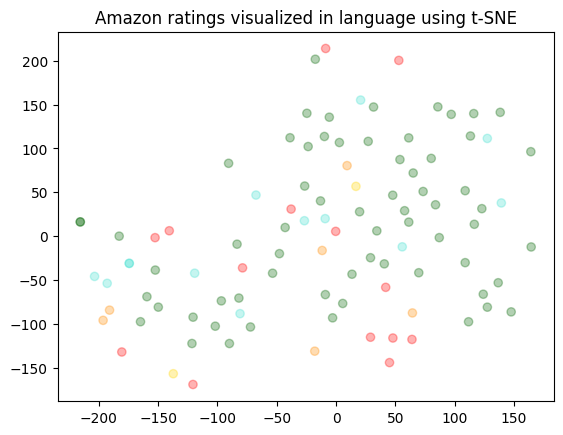

In [92]:
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架
import matplotlib.pyplot as plt
import matplotlib

# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

print(vis_dims)
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.Score.values)

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

plt.title("Amazon ratings visualized in language using t-SNE")

In [76]:
from sklearn.cluster import KMeans

# 定义要生成的聚类数。
n_clusters = 4

# init 参数指定了初始化方法（在这种情况下是 'k-means++'）
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded["Cluster"] = kmeans.labels_

In [77]:
df_embedded["Cluster"]

0     1
1     3
2     2
3     0
4     3
     ..
95    1
96    1
97    3
98    2
99    3
Name: Cluster, Length: 100, dtype: int32

In [78]:
df_embedded.head(2)

,Id,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,Cluster
0,8004,B006O8AGOM,A3MSOTU8Z1PDH9,1,You get what you pay for,Caribbean Joy coconut milk offers a tempting p...,Title: You get what you pay for; Content: Cari...,81,"[0.0010586663847789168, -0.015894677489995956,...","[0.0010586663847789168, -0.015894677489995956,...",1
1,5695,B00434J6YK,A3MUDX3JZDUEE8,5,Love them,It's been a month or so since I read the other...,Title: Love them; Content: It's been a month o...,286,"[-0.024149755015969276, -0.028316296637058258,...","[-0.024149755015969276, -0.028316296637058258,...",3


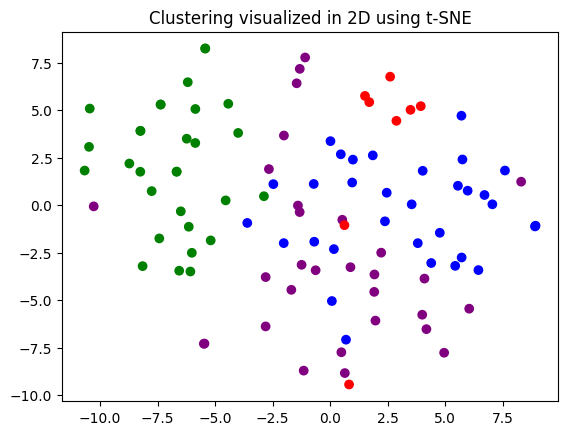

In [79]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 embedding_vec 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# Cluster 列中的值将被用作颜色索引。
color_indices = df_embedded["Cluster"].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

plt.title("Clustering visualized in 2D using t-SNE")

plt.show()

In [80]:
type(df_embedded["embedding_vec"][0])

list

In [81]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度
# 余弦相似度是一种常用的方法。余弦相似度是基于向量之间的夹角来衡量它们之间的相似程度，而不考虑向量的大小
from openai.embeddings_utils import cosine_similarity

"""
用于在给定的 DataFrame df 中搜索与给定 product_description 最相似的产品评论

pandas DataFrame
产品描述
数量
以及一个 pprint 标志（默认值为 True）
"""
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(product_description)
    df["similarity"] = df.embedding_vec.apply(
        lambda x: cosine_similarity(x, product_embedding)
    )

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [82]:
res = search_reviews(df_embedded, "dog food", n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Good for dogs that are food intolerant:  I have a great dane - she is very food intolerant; she cannot tolerate brown rice, beef, lamb, sweet potato nor large amounts of broccoli, spinach, peas, and n

Love it:  My three little dogs love this food and I love it too sense it is organic and has no animal by products.



In [83]:
df_embedded["combined"][0]

"Title: You get what you pay for; Content: Caribbean Joy coconut milk offers a tempting price, lower than its competitors.  There's a good reason for its low price: by all accounts it tastes like half the visible amount is coconut milk, the rest being water.<br />Neither good for pina coladas or cooking, this is a poor value and I can't recommend it to anyone."

In [84]:
res = search_reviews(df_embedded, df_embedded["combined"][0], n=3)

You get what you pay for:  Caribbean Joy coconut milk offers a tempting price, lower than its competitors.  There's a good reason for its low price: by all accounts it tastes like half the visible amo

It's office hot cocoa - but add milk and it's halfway decent:  I didn't expect much from powdered cocoa in a cup, but here's a tip: put on 8oz setting, then add a 1:1 ratio of heated milk. It tastes a

Caribou Mahogany:  Got this in a k cup sampler, the best k cup so far.  If you like good strong coffee with a lot of flavor, slight hint of cocoa, this is it.  No bitter after taste.  This one goes on

